<a href="https://colab.research.google.com/github/AudeAymone/-Braille_App-Api/blob/main/Braille_app_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importation de librairies
import sys
import cv2
import scipy
import random
import imageio.v2 as imageio
import numpy as np
import zipfile as zf
import matplotlib.pyplot as plt
from scipy import ndimage
from imageio import imread
from skimage.feature import hog
from scipy.ndimage import shift
from skimage.transform import resize
from sklearn.metrics import accuracy_score
from PIL import Image, ImageDraw, ImageFont
from skimage.util import random_noise, invert
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import os

alphabet = {
  repr([1, 0, 0, 0, 0, 0]) : "a",\
  repr([1, 0, 1, 0, 0, 0]) : "b",\
  repr([1, 1, 0, 0, 0, 0]) : "c",\
  repr([1, 1, 0, 1, 0, 0]) : "d",\
  repr([1, 0, 0, 1, 0, 0]) : "e",\
  repr([1, 1, 1, 0, 0, 0]) : "f",\
  repr([1, 1, 1, 1, 0, 0]) : "g",\
  repr([1, 0, 1, 1, 0, 0]) : "h",\
  repr([0, 1, 1, 0, 0, 0]) : "i",\
  repr([0, 1, 1, 1, 0, 0]) : "j",\
  repr([1, 0, 0, 0, 1, 0]) : "k",\
  repr([1, 0, 1, 0, 1, 0]) : "l",\
  repr([1, 1, 0, 0, 1, 0]) : "m",\
  repr([1, 1, 0, 1, 1, 0]) : "n",\
  repr([1, 0, 0, 1, 1, 0]) : "o",\
  repr([1, 1, 1, 0, 1, 0]) : "p",\
  repr([1, 1, 1, 1, 1, 0]) : "q",\
  repr([1, 0, 1, 1, 1, 0]) : "r",\
  repr([0, 1, 1, 0, 1, 0]) : "s",\
  repr([0, 1, 1, 1, 1, 0]) : "t",\
  repr([1, 0, 0, 0, 1, 1]) : "u",\
  repr([1, 0, 1, 0, 1, 1]) : "v",\
  repr([0, 1, 1, 1, 0, 1]) : "w",\
  repr([1, 1, 0, 0, 1, 1]) : "x",\
  repr([1, 1, 0, 1, 1, 1]) : "y",\
  repr([1, 0, 0, 1, 1, 1]) : "z",\
  repr([1, 1, 1, 1, 0, 1]) : "ç",\
  repr([1, 1, 1, 1, 1, 1]) : "é",\
  repr([1, 1, 1, 0, 1, 1]) : "à",\
  repr([0, 1, 1, 1, 1, 1]) : "ù",\
  repr([1, 0, 0, 0, 0, 1]) : "1",\
  repr([1, 1, 0, 0, 0, 1]) : "2",\
  repr([1, 0, 0, 1, 0, 1]) : "3",\
  repr([1, 0, 0, 1, 1, 1]) : "4",\
  repr([1, 0, 0, 0, 1, 1]) : "5",\
  repr([1, 1, 0, 1, 0, 1]) : "6",\
  repr([1, 1, 0, 1, 1, 1]) : "7",\
  repr([1, 1, 0, 0, 1, 1]) : "8",\
  repr([0, 1, 0, 1, 0, 1]) : "9",\
}


In [ ]:
#Déclarations de fonctions
#Amélioration de l'image

# # Normalise les pixels de l'image entre 0 et 255
def normalize(img):
	imin = np.min(img)
	imax = np.max(img)

	return (((img - imin)/(imax - imin)) * 255).astype(np.float64)

# Imprime l'image avec une valeur minimale égale à 0 et maximale à 255
def printNormalizedImage(img):
	plt.figure(figsize=(16,8))
	plt.imshow(img, cmap="gray", vmin=0, vmax=255)

# Imprime l'image avec les valeurs par défaut de matplotlib
def printImage(img):
	plt.figure(figsize=(16,8))
	plt.imshow(img, cmap="gray")

# Filtre de différence médiane, met en évidence les pixels d'ombre
def Filter(I, n):
	m = n//2
	J = np.empty(I.shape, dtype=np.float64)
	N, M = I.shape
	I = np.pad(I, ((m, m), (m, m)), 'symmetric')

	for i in range(N):
		for j in range(M):
			sub = I[i+m:(i+m+n), j+m:(j+m+n)]
			med = np.median(np.ravel(sub)) # gets median
			J[i, j] = abs(I[i+m, j+m] - med) # applies the difference
	return J

#Applique le filtre moyen à l'image I
def MeanFilter(I, n):
	m = n//2
	J = np.empty(I.shape, dtype=np.float64) # the answer
	N, M = I.shape
	I = np.pad(I, ((m, m), (m, m)), 'symmetric')
	for	i in range(N):
		for j in range(M):
			# copie la matrice dans le sub
			sub = I[i+m:(i+m+n), j+m:(j+m+n)]
			J[i, j] = np.mean(np.ravel(sub)) # get mean of the linearized list
	return J

# Transformer une image RVB en une image en niveaux de gris
def RGBtoGrayScale(matrix):
  if (matrix.ndim == 2): return matrix

  size = matrix.shape
  for i in range(size[0]):
    for j in range(size[1]):
      matrix[i, j, 0] = matrix[i, j, 0] * 0.2989 + matrix[i, j, 1] * 0.5870 + matrix[i, j, 2] * 0.1140

  matrix = matrix[:, :, 0].squeeze()

  return matrix

# Appliquer le filtre de seuil donné T
def ThresholdFilter(matrix, T=1):
  size = matrix.shape
  for i in range(size[0]):
    for j in range(size[1]):
      matrix[i, j] = 0 if matrix[i, j] < T else 1

  return matrix


In [ ]:

#Génération de matrice binaire


# nom de fichier de l'image d'entrée
filename = "./image/image.png"
image = imageio.imread(filename)
matrix = np.array(image, copy=True, dtype=np.float64)

size = matrix.shape

N = size[0]
M = size[1]

sys.setrecursionlimit(10 * N * M)

# Tracer l'image d'origine
matrix = RGBtoGrayScale(matrix)
matrix = normalize(matrix)
mat = matrix.astype(np.uint8)

#Déclarations de fonction

dots_matrix = Filter(matrix, 21) # Applies filter to normalized matrix
dots_matrix = normalize(dots_matrix)

# Image lisse à l'aide d'un filtre moyen, pour réduire le bruit
dots_matrix = MeanFilter(dots_matrix, 3)

# Pas de seuil, 30 est une valeur arbitraire dérivée du test avec des images, mais indépendante de l'échelle de gris de l'image d'entrée
dots_matrix = ThresholdFilter(dots_matrix, 30)



In [ ]:
# Éroder les régions pour calculer des cercles
dots_matrix = ndimage.binary_erosion(dots_matrix)

# Tracer une image segmentée
mat = dots_matrix.astype(np.uint8)

#Correction des zones blanches indésirables

dots_matrix = Filter(matrix, 21)

# Applique le filtre à la matrice normalisée
dots_matrix = normalize(dots_matrix)

# Image lisse à l'aide d'un filtre moyen, pour réduire le bruit
dots_matrix = MeanFilter(dots_matrix, 3)

# Pas de seuil, 30 est une valeur arbitraire dérivée du test avec des images, mais indépendante de l'échelle de gris de l'image d'entrée
dots_matrix = ThresholdFilter(dots_matrix, 30)


# Éroder les régions pour calculer des cercles
dots_matrix = ndimage.binary_erosion(dots_matrix)

# Tracer une image segmentée
mat = dots_matrix.astype(np.uint8)

# Déterminer le diamètre d'un cercle braille

# Trouve les points de l'image qui sont dans un composant connexe
def pointsInComponent(matrix, i, j, pts):
	vis[i, j] = 1
	pts.append((i, j))
	if i + 1 < N and vis[i+1, j] == 0 and matrix[i+1, j] == 1: pointsInComponent(matrix, i+1, j, pts)
	if i - 1 >=0 and vis[i-1, j] == 0 and matrix[i-1, j] == 1: pointsInComponent(matrix, i-1, j, pts)
	if j + 1 < M and vis[i, j+1] == 0 and matrix[i, j+1] == 1: pointsInComponent(matrix, i, j+1, pts)
	if j - 1 >=0 and vis[i, j-1] == 0 and matrix[i, j-1] == 1: pointsInComponent(matrix, i, j-1, pts)

# Algorithme de remplissage d'inondation pour peindre les régions blanches indésirables
def paintBlack(matrix, i, j):
	matrix[i, j] = 0
	if i + 1 < N and matrix[i+1, j] == 1: paintBlack(matrix, i+1, j)
	if i - 1 >=0 and matrix[i-1, j] == 1: paintBlack(matrix, i-1, j)
	if j + 1 < M and matrix[i, j+1] == 1: paintBlack(matrix, i, j+1)
	if j - 1 >=0 and matrix[i, j-1] == 1: paintBlack(matrix, i, j-1)


In [ ]:

# Fonction de corrélation d'histogramme CV
def compare(a, b):
	return cv2.compareHist(np.array(a).astype('float32'), np.array(b).astype('float32'), cv2.HISTCMP_CORREL)

# Fonction de comparaison de distance euclidienne
def euclideanDistance(a, b):
	return (np.sum((np.array(a) - np.array(b))**2)/256)**(1/2)

# Segment image into blocks and determine which letter it represents

vis = np.zeros((N, M))

# Récupérer les composants (régions blanches) et ses pixels
comp = []
for i in range(N):
	for j in range(M):
		if vis[i, j] == 0 and dots_matrix[i, j] == 1:
			comp.append([])
			pointsInComponent(dots_matrix, i, j, comp[-1])

# Calculer les histogrammes de chaque région en utilisant la compréhension de liste
histograms = [
	np.histogram(np.array([matrix[x] for x in pts]), bins=256, range=(0, 255))[0]
	for pts in comp
]

sz = np.median([len(x) for x in comp])

# description de l'histogramme du cercle braille, il est calculé comme moyenne pondérée des histogrammes des régions blanches, dans lesquelles le poids est sa centralité
desc = []

for c in range(256):
	desc.append(0)
	sum = 0 # sommes de poids
	for i in range(len(comp)):
		if abs(len(comp[i]) - sz) > sz: continue
		p, q = comp[i][0]
		w = np.min([(p+1), (N - p+1), (q+1), (M - q + 1)]) # weight of the region, its centrality
		w = w/(len(comp))
		sum += w
		desc[c] += w * histograms[i][c]
	desc[c] /= sum


errors = []
for i in range(len(histograms)):
	errors.append(compare(desc, histograms[i]))
	if compare(desc, histograms[i]) < 0 or euclideanDistance(desc, histograms[i]) > 1: #if correlation between the two histograms is less than 0.05, paint it black
		paintBlack(dots_matrix, comp[i][0][0], comp[i][0][1])


In [ ]:

# Tracer une image segmentée
mat = dots_matrix.astype(np.uint8)
print(mat)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# calcul du diamètre moyen
diam = 0.0
for i in range(len(comp)):
  if abs(len(comp[i]) - sz) > sz: continue
  lo = N
  for pt in comp[i]: lo = min(lo, pt[0])
  hi = 0
  for pt in comp[i]: hi = max(hi, pt[0])

  v = hi - lo + 1
  lo = M
  for pt in comp[i]: lo = min(lo, pt[1])
  hi = 0
  for pt in comp[i]: hi = max(hi, pt[1])

  v = max(v, hi - lo + 1)
  diam += v

diam /= len(comp)
diam = round(diam)


In [ ]:
!unzip train.zip

Archive:  train.zip
  inflating: train/1.png             
  inflating: train/10.png            
  inflating: train/11.png            
  inflating: train/12.png            
  inflating: train/13.png            
  inflating: train/14.png            
  inflating: train/15.png            
  inflating: train/16.png            
  inflating: train/17.png            
  inflating: train/18.png            
  inflating: train/19.png            
  inflating: train/2.png             
  inflating: train/20.png            
  inflating: train/21.png            
  inflating: train/22.png            
  inflating: train/23.png            
  inflating: train/24.png            
  inflating: train/25.png            
  inflating: train/26.png            
  inflating: train/3.png             
  inflating: train/4.png             
  inflating: train/5.png             
  inflating: train/6.png             
  inflating: train/7.png             
  inflating: train/8.png             
  inflating: train/9.png      

In [ ]:
# Fonction pour appliquer du bruit et générer des images d'entrainement

def gen_data(base_image, quantity, label, data, target, shift_value=4):
	for i in range(quantity):
		data.append(shift(base_image, [random.randint(-shift_value,shift_value), random.randint(-shift_value,shift_value)]))
		target.append(label)

# Lire les images du train
images = []
for i in range(1, 27):
	images.append(RGBtoGrayScale(imageio.imread("train/" + str(i) + ".png")))

X = []
Y = []

for i in range(26):
	gen_data(invert(images[i]), 30 , i+1, X, Y)

In [ ]:
x = []

# set training set as hog vector of images
for i in X:
	x.append(hog(i, block_norm='L2-Hys',  pixels_per_cell=(2,2), visualize=False))

x = np.asarray(x)
y = np.asarray(Y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

# train model using 80% of generated images
clf = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=500, tol=1e-3)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print (accuracy_score(y_test, y_pred))

0.8141025641025641


In [ ]:
# déterminer la lettre en utilisant une approche manuelle
def find_letter(img):
	assert(img.shape == (hei, wid))
	vec = [0 for _ in range(6)]
	for k in range(6):
		i = k//2
		j = k%2
		tot = np.count_nonzero(img[i*2*diam:i*2*diam + 2*diam, j*2*diam:j*2*diam + 2*diam])
		vec[k] = 1 if tot > 0.2*diam*diam else 0
#Définir le fait que les symboles vides de sens aient comme traduction "#"
	if repr(vec) in alphabet:
		return alphabet[repr(vec)]
	return '#'

letters_manual = []
wid = 4 * diam
hei = 6 * diam

copy_matrix = np.copy(dots_matrix)

for i in range(N):
	for j in range(M-1, -1, -1):
		if i-hei+1 < 0 or j+wid-1 >= M: continue
		tot = np.count_nonzero(copy_matrix[i-hei+1:i+1, j:j+wid])
		if tot == 0: continue
		##Grand rectangle
		tot2 = np.count_nonzero(copy_matrix[max(0, i-12*diam+1):min(i+6*diam+1, N), max(0, j-4*diam):min(M, j+8*diam)])
		offset = diam//2
		if tot2 == tot and i-hei+1 + offset >= 0 and i + 1 + offset <= N and j-offset >= 0 and j + wid - offset <= M:
			#Nous avons trouvé un modèle, le couper
			pattern = copy_matrix[i-hei+1 + offset:i+1 + offset, j-offset:j+wid-offset]
			#print(pattern)
			c = find_letter(pattern)
			if c == '#' and i+offset + 2*diam < N:
				pattern = copy_matrix[i-hei+1 + offset + 2 * diam: i+1+offset + 2*diam, j-offset:j+wid-offset]
				c = find_letter(pattern)
			if c == '#' and i+offset + 4*diam < N:
				pattern = copy_matrix[i-hei+1 + offset + 4 * diam: i+1+offset + 4*diam, j-offset:j+wid-offset]
				c = find_letter(pattern)

			letters_manual.append((i-hei+1, j, c))
			copy_matrix[i-hei+1:i+1, j:j+wid] = 0


In [ ]:
!unzip font.zip

Archive:  font.zip
  inflating: font/Poppins-SemiBoldItalic.ttf  


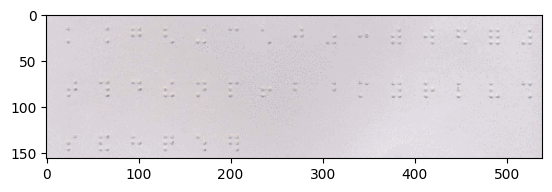

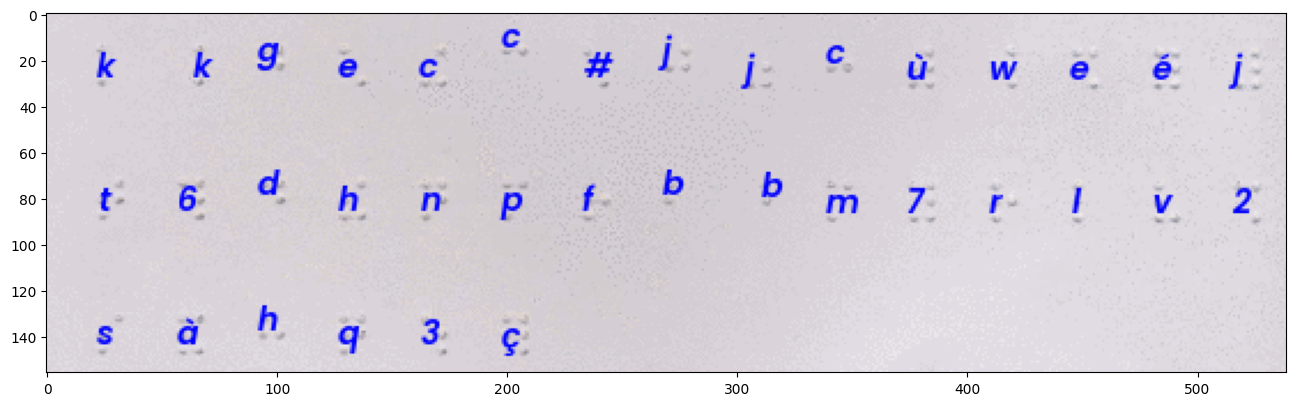

In [ ]:
# Dessine les lettres au-dessus des cases
img_manual = Image.open(filename).convert('RGBA')
fnt = ImageFont.truetype('font/Poppins-SemiBoldItalic.ttf', 14)
d = ImageDraw.Draw(img_manual)
for x, y, c in letters_manual:
	d.text((y, x), "" + c, font=fnt, fill=(0, 0, 255, 255))
plt.imshow(image)
plt.figure(figsize=(16,8))
plt.imshow(img_manual)
save_path = os.path.join(os.getcwd(), 'image', 'imageTraitee.png')
img_manual.save(save_path)
plt.show()